In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")

### Import Desired Tires

In [15]:
all_tires = {
    # "Hoosier_18x6.0-10_LCO_6_cornering":{"long":None, "lat":None},
    # "Worn_Hoosier_18x6.0-10_LCO_6_cornering":{"long":None, "lat":None},
    # "Hoosier_18x6.0-10_LCO_7_cornering":{"long":None, "lat":None},
    # "Worn_Hoosier_18x6.0-10_LCO_7_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_6_cornering":{"long":None, "lat":None},
    "Worn_Hoosier_18x6.0-10_R20_6_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_7_cornering":{"long":None, "lat":None},
    "Worn_Hoosier_18x6.0-10_R20_7_cornering":{"long":None, "lat":None},
}

### Filter Data

In [16]:
camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
tire_scaling = 2/3

tire_dict = all_tires.items()

for name, tire in tire_dict:
    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["camber"] == camber) & (df["slip"] == slip_angle)]
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["lat"] = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    except:
        print("Error getting lateral data for {0}".format(name))

tire_lst = list(all_tires.items())
tires_grouped = [[tire_lst[2 * i], tire_lst[2 * i + 1]] for i in range(int(len(tire_lst) / 2))]

### Calculate Lateral Friction Coefficients

In [17]:
peak_mu_lst = []
worn_peak_mu_lst = []
normal_load_lst = []
tire_name = []
worn_tire_name = []

normal_loads = sorted(np.array(tire["lat"]["load"].unique()))

for tire_tuple in tires_grouped:
    name = tire_tuple[0][0]
    data = tire_tuple[0][1]
    worn_name = tire_tuple[1][0]
    worn_data = tire_tuple[1][1]
    
    current_peak_mu = []
    worn_current_peak_mu = []

    current_normal_load = []

    for load in normal_loads:
        if load > -400:
            continue
        # plt.figure()
        temp = data["lat"][data["lat"]["load"] == load]
        worn_temp = worn_data["lat"][worn_data["lat"]["load"] == load]
        # plt.plot(temp["SA"], temp["FY"])
        # plt.plot(worn_temp["SA"], worn_temp["FY"])
        peak_mu = max(temp["FY"]) * 2/3 / abs(load)
        worn_peak_mu = max(worn_temp["FY"] * 2/3 / abs(load))

        current_peak_mu.append(peak_mu)
        worn_current_peak_mu.append(worn_peak_mu)
        current_normal_load.append(load)

    normal_load_lst.append(current_normal_load)
    peak_mu_lst.append(current_peak_mu)
    worn_peak_mu_lst.append(worn_current_peak_mu)
    tire_name += [worn_name, name[:23]]

### Plot Difference Between Initial and Final Mu

Text(0, 0.5, 'Mu Difference')

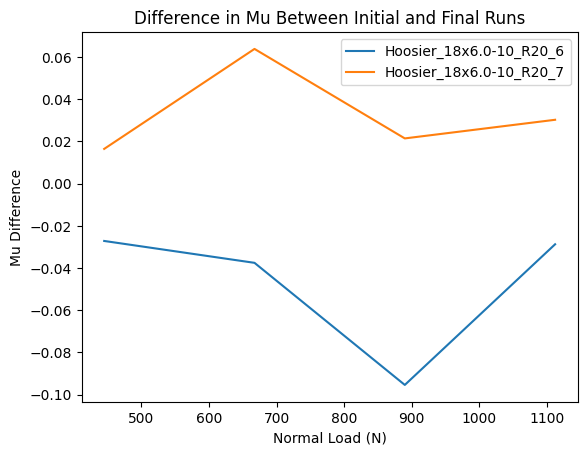

In [18]:
adjusted_names = tire_name[1::2]

for i in range(len(peak_mu_lst)):

    net_mu = np.array(peak_mu_lst[i]) - np.array(worn_peak_mu_lst[i])

    adjusted_FZ = -1 * np.array(normal_load_lst[i])
    plt.plot(adjusted_FZ, net_mu)

    # plt.scatter(adjusted_FZ, net_mu)

plt.ylim(-0.2, 0.2)
plt.legend(adjusted_names)
plt.title("Difference in Mu Between Initial and Final Runs")
plt.xlabel("Normal Load (N)")
plt.ylabel("Mu Difference")